Análisis de datos en salud
============================

Unidad 4
-----------------------------------------------------



In [55]:
# Montamos la unidad Drive para acceder a los archivos de Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Especificamos la ruta hasta la carpeta donde tenemos los archivos de la Unidad 4
%cd /content/drive/MyDrive/Colab_Notebooks/Analisis_datos_salud/Unidad4


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/Analisis_datos_salud/Unidad4


## Datos de informes médicos

Los datos de este dataset provienen del Departamento de Atención Médica Administrada de California (DMHC). Contiene todas las decisiones de Revisiones Médicas Independientes (IMR, por sus siglas en inglés) administradas por el DMHC desde el 1 de enero de 2001. Una IMR es una revisión independiente de un servicio de atención médica denegado, demorado o modificado que el plan de salud ha determinado que no es médicamente necesario, experimental/investigacional o no urgente/emergente. Si la IMR se decide a favor del afiliado, el plan de salud debe autorizar el servicio o tratamiento solicitado.


### Ejercicio 1

**(1 punto)**

a) Primero de todo vamos a explorar un poco el dataset `IMR_review.csv`. Carga los datos y muestra su tamaño y el nombre de las columnas. Muestra también por pantalla las 5 primeras filas. **(0.25 puntos)**

b) ¿Hay algún valor perdido (*missing*) (NaN) o fila duplicada en el dataset? Si los hay, elimina esas filas. **(0.25 puntos)**

c) En la variable `Type` tenemos información sobre el tipo de atención médica ¿Qué porcentaje hay de cada categoría? ¿Es un dataset balanceado? **(0.5 puntos)**

In [56]:
#a)

# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import string
from wordcloud import WordCloud
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay


# Cargamos el archivo csv en un DataFrame
imr_df = pd.read_csv("data/IMR_review.csv", sep=",")

# Mostramos el tamaño del df
print("Tamaño df:\n", imr_df.shape)

# Mostramos el nombre de las columnas
print("Columnas del df:\n", imr_df.columns)

# Visualizamos las 5 primeras filas con el comando head()
imr_df.head()

Tamaño df:
 (19245, 11)
Columnas del df:
 Index(['Reference ID', 'Report Year', 'Diagnosis Category',
       'Diagnosis Sub Category', 'Treatment Category',
       'Treatment Sub Category', 'Determination', 'Type', 'Age Range',
       'Patient Gender', 'Findings'],
      dtype='object')


,Reference ID,Report Year,Diagnosis Category,Diagnosis Sub Category,Treatment Category,Treatment Sub Category,Determination,Type,Age Range,Patient Gender,Findings
0,MN16-22639,2016,Infectious,Hepatitis,Pharmacy/Prescription Drugs,Anti-virals,Overturned Decision of Health Plan,Medical Necessity,41-50,Male,Nature of Statutory Criteria/Case Summary: An ...
1,MN16-22638,2016,Mental,Eating Disorder,Mental Health Treatment,Residential Treatment Center - Admission,Upheld Decision of Health Plan,Medical Necessity,21-30,Female,Nature of Statutory Criteria/Case Summary: An...
2,MN16-22637,2016,Autism Spectrum,Autism-PDD-NOS,Autism Related Treatment,Speech Therapy,Upheld Decision of Health Plan,Medical Necessity,0-10,Female,Nature of Statutory Criteria/Case Summary: Th...
3,EI16-22636,2016,Prevention/Good Health,NaN,"Diagnostic Imaging, Screening and Testing",Mammography,Overturned Decision of Health Plan,Experimental/Investigational,65+,Female,Nature of Statutory Criteria/Case Summary: An ...
4,EI06-5319,2006,Cardiac/Circulatory,NaN,Cardio Vascular,NaN,Upheld Decision of Health Plan,Experimental/Investigational,51-64,Male,Physician 1: The patient is a 62-year-old male...


In [57]:
# Mostramos el tipo de las variables
print(imr_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19245 entries, 0 to 19244
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Reference ID            19245 non-null  object
 1   Report Year             19245 non-null  int64 
 2   Diagnosis Category      19186 non-null  object
 3   Diagnosis Sub Category  17341 non-null  object
 4   Treatment Category      18795 non-null  object
 5   Treatment Sub Category  17977 non-null  object
 6   Determination           19245 non-null  object
 7   Type                    19245 non-null  object
 8   Age Range               18035 non-null  object
 9   Patient Gender          18035 non-null  object
 10  Findings                19225 non-null  object
dtypes: int64(1), object(10)
memory usage: 1.6+ MB
None


In [58]:
#b) Gestión de duplicados y NaNs

#Miramos si hay duplicados
print("Filas duplicadas:", imr_df.duplicated().sum())

# No hay filas duplicadas!

Filas duplicadas: 0


In [59]:
# Hay valores nulos en el df
imr_df.isna().sum()

,0
Reference ID,0
Report Year,0
Diagnosis Category,59
Diagnosis Sub Category,1904
Treatment Category,450
Treatment Sub Category,1268
Determination,0
Type,0
Age Range,1210
Patient Gender,1210


In [60]:
imr_df = imr_df.dropna()

# Ya no hay valores nulos en el df
imr_df.isna().sum()

,0
Reference ID,0
Report Year,0
Diagnosis Category,0
Diagnosis Sub Category,0
Treatment Category,0
Treatment Sub Category,0
Determination,0
Type,0
Age Range,0
Patient Gender,0


In [61]:
# c) Estudiamos la variable Type
# Ahora estudiamos la poporción de la clase Type
print("Proporción de tipo de IMR:")
print(imr_df['Type'].value_counts(normalize=True),"\n")

# ¡Tenemos un dataset desbalanceado!

Proporción de tipo de IMR:
Type
Medical Necessity               0.708887
Experimental/Investigational    0.264053
Urgent Care                     0.027060
Name: proportion, dtype: float64 



### Ejercicio 2

**(1.5 puntos)**


a) Antes de poder usar la información textual en el modelo, tenemos que preprocesarla. Para conseguirlo, vamos a llevar a cabo los pasos siguientes:

- Pasar todo el texto a minúsculas.
- Eliminar signos de puntuación.
- Eliminar *stop words*
- Proceso de stemming
- Crear una nueva columna con las clases de Type codificadas como 0, 1 y 2.

**(0.5 puntos)**

b) Ahora vamos a mostrar las palabras más frecuentes según la clase de Type con la visualización de **Nube de palabras** (*World Cloud*). Sigue la metodología usada en el ejercicio de la parte práctica para crear la nube de palabras. Especifica un máximo de 250 palabras para que no salgan demasiadas. Muestra la nube de palabras para las tres clases de Type. **Opcional**

c) También se pueden representar las palabras más frecuentes con gráficos más básicos. Usa [Counter](https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list) para contar e identificar las 25 palabras más frecuentes para cada clase de Type. A continuación, selecciona aquellas palabras no comunes entre grupos (por ejemplo, si la palabra patient aparece como frecuente en más de un grupo, se eliminará de la lista). Finalmente, muestra las palabras únicas más frecuentas para cada clase de Type con un gráfico de barras para cada categoría (en este caso, tendremos 3 gráficos de barras ya que tenemos 3 categorías en Type). **(1 punto)**

In [62]:
# a) Preproceso básico del texto

# Hacemos una copia del df original
df_clf = imr_df.copy()

# 1) Pasar texto a minúsculas

# Creamos una función que convierte el texto el minúsculas
def convert_lowercase(text):
    text = text.lower()
    return text

# Aplicamos esta función a nuestros datos
df_clf['Findings'] = df_clf['Findings'].apply(convert_lowercase)

In [63]:
# 2) Eliminar signos de puntación

# Seleccionamos los signpos de puntuación que queremos eliminar
exclude = string.punctuation
print('Signos de puntuación:', exclude)

# Creamos una función que elimina los signos de la lista exclude
def remove_punc(text):
    return text.translate(str.maketrans('', '', exclude))

# Aplicamos esta función a nuestros datos
df_clf['Findings'] = df_clf['Findings'].apply(remove_punc)

Signos de puntuación: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [64]:
# 3) Eliminar stop words

# Tenemos que descargar las stopwords de NLTK
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Creamos una función que:
# 1) Tokaniza el texto
# 2) Si los elementos no son stop words, los añade a una nueva lista
# 3) Se concantenan los elementos de la lista separándolos por un espacio

weird_elem = '’'
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if (word not in stopwrds) and (word not in weird_elem):
            new_list.append(word)
    return ' '.join(new_list)

# Aplicamos esta función a nuestros datos
df_clf['Findings'] = df_clf['Findings'].apply(remove_stopwords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
# 4) Proceso de Stemming

# Necesitamos descargar punkt
nltk.download('punkt')

# Usamos la función SnowballStemmer para aplicar el stemming
# a las palabras del texto. Por este motivo, se tienen que tokenizar otra vez
def perform_stemming(text):
    stemmer = SnowballStemmer('english')
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

# Aplicamos esta función a nuestros datos
df_clf['Findings'] = df_clf['Findings'].apply(perform_stemming)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [66]:
# 5) Crear columna de Type en formato numérico

df_clf["Type_encoded"] = df_clf["Type"].replace({
        "Medical Necessity" : 0,
        "Experimental/Investigational": 1,
        "Urgent Care": 2
})

In [67]:
# Mostramos la primeras fila del dataset original

imr_df['Findings'][0]

'Nature of Statutory Criteria/Case Summary: An enrollee has requested Harvoni for treatment of his hepatitis C virus genotype 1a.  Findings:  The physician reviewer found that according to the most recent joint guidelines issued by the American Association for the Study of Liver Diseases (AASLD) and the Infectious Diseases Society of America (IDSA), all patients with chronic hepatitis C should be treated except those with limited life expectancy due to non-liver-related conditions. This applies regardless of fibrosis stage or viral load, and advanced fibrosis is not required for treatment. Per guidelines, treatment-naïve genotype 1 patients should be treated with Harvoni. Patients with viral load of less than 6,000,000 IU/mL can be treated for eight weeks. These guideline recommendations are based on multiple randomized clinical trials (Kowdley, et al; Afdhal, et al). Moreover, the AASLD and IDSA guidelines cite data showing reduced survival with delayed treatment (Jezequel, et al). Fo

In [68]:
# Mostramos la primera fila del dataset preprocesado
df_clf['Findings'][0]

'natur statutori criteriacas summari enrolle request harvoni treatment hepat c virus genotyp 1a find physician review found accord recent joint guidelin issu american associ studi liver diseas aasld infecti diseas societi america idsa patient chronic hepat c treat except limit life expect due nonliverrel condit appli regardless fibrosi stage viral load advanc fibrosi requir treatment per guidelin treatmentnaïv genotyp 1 patient treat harvoni patient viral load less 6000000 iuml treat eight week guidelin recommend base multipl random clinic trial kowdley et al afdhal et al moreov aasld idsa guidelin cite data show reduc surviv delay treatment jezequel et al reason request treatment harvoni support medic necessari treatment patient hepat c infect final result review determin request medic medic necessari treatment patient medic condit therefor health plan denial overturn credentialsqualif review board certifi intern medicin subspecialti certif gastroenterolog activ practic review expert 

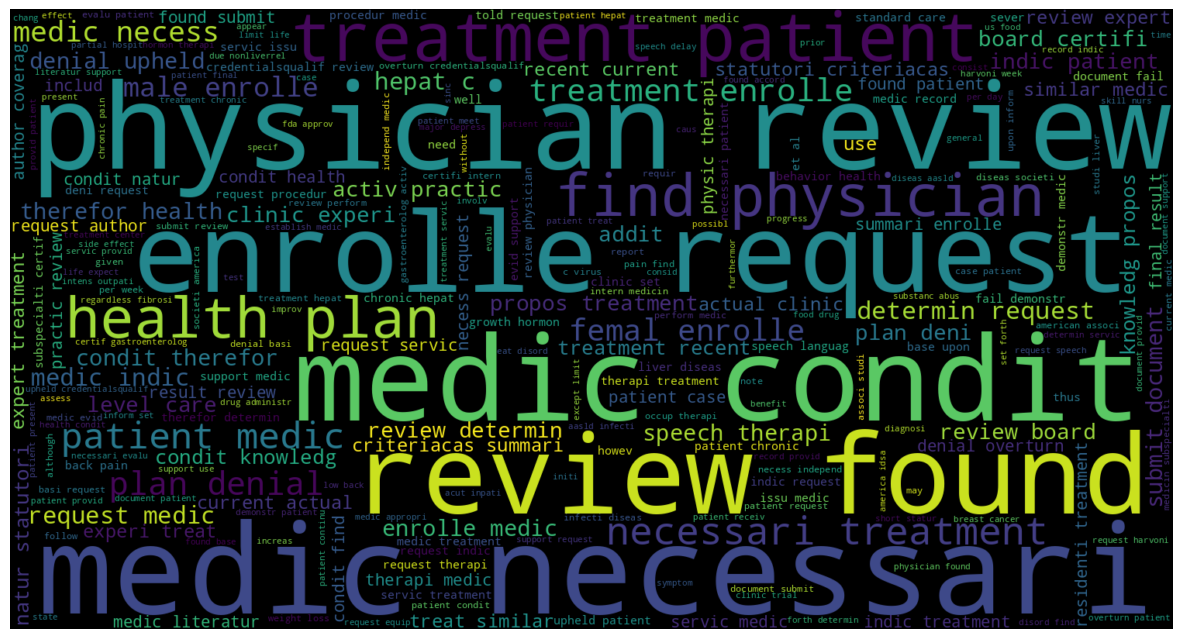

In [69]:
# b) Nube de palabras -- Opcional

# Word Cloud con Type 'Medical Necessity'

# Vamos primero a juntar todos los textos que tienen label 0
text0 = " ".join(df_clf[df_clf['Type'] == 'Medical Necessity']['Findings'])

# Ahora vamos a usar la función WordCloud para mostrar gráficamente las palabras que aparecen más en el texto
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=250, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text0)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

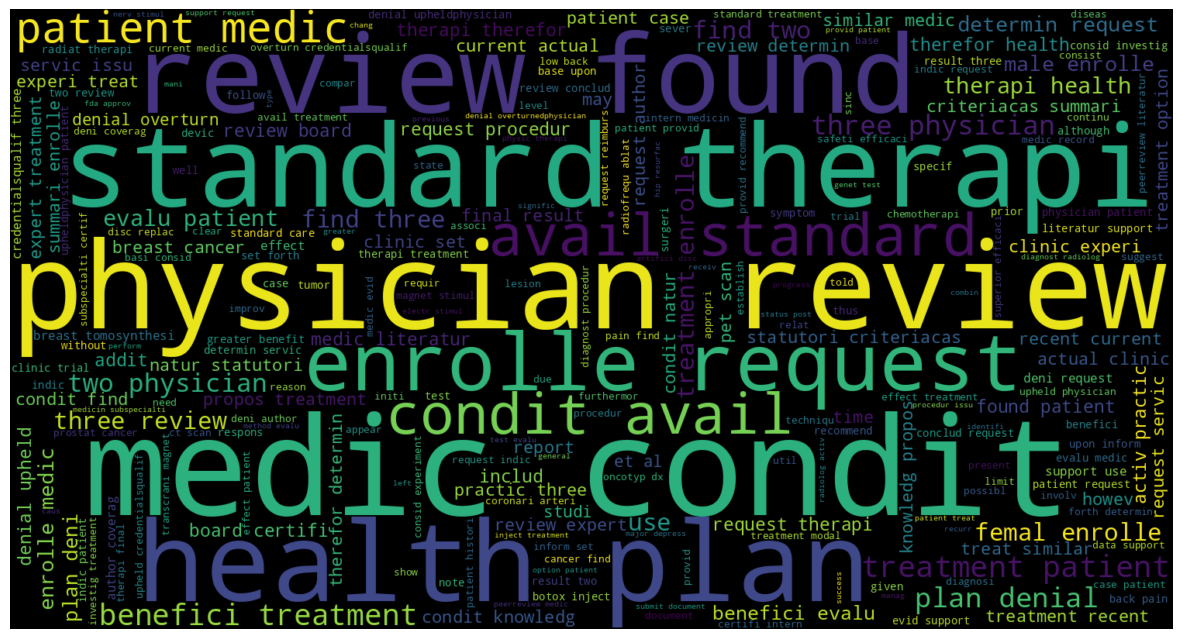

In [70]:
# Word Cloud con Type 'Experimental/Investigational'

# Vamos primero a juntar todos los textos que tienen Type 'Experimental/Investigational'
text1 = " ".join(df_clf[df_clf['Type'] == 'Experimental/Investigational']['Findings'])

# Ahora vamos a usar la función WordCloud para mostrar gráficamente las palabras que aparecen más en el texto
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=250, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text1)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

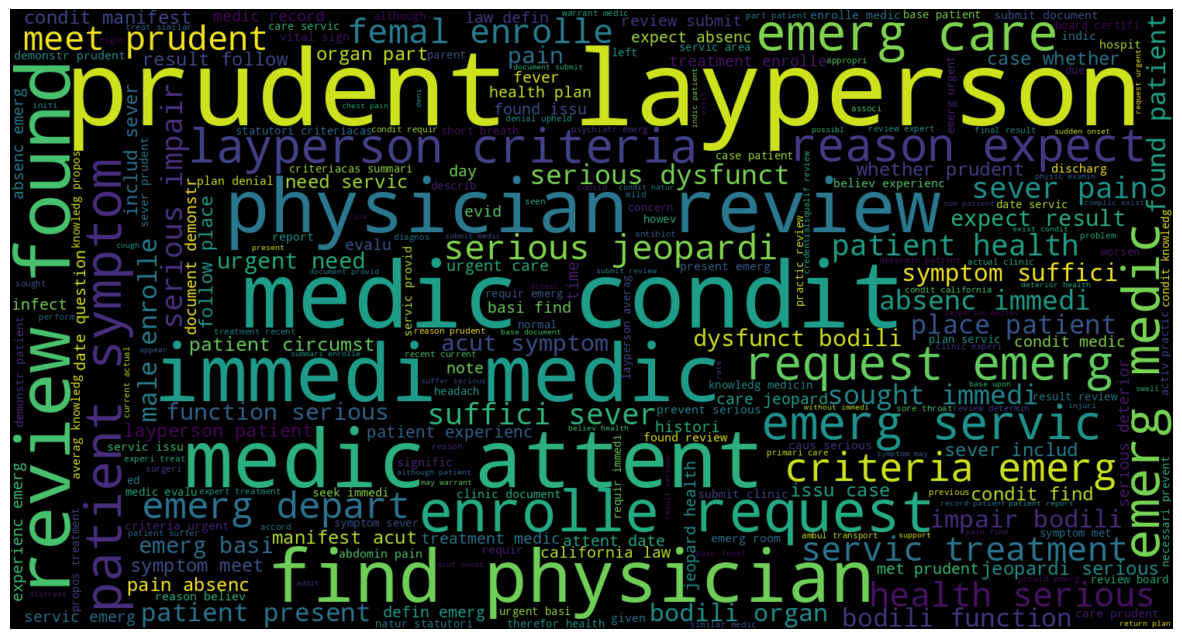

In [71]:
# Word Cloud con Type 'Urgent Care'

# Vamos primero a juntar todos los textos que tienen Type 'Urgent Care'
text2 = " ".join(df_clf[df_clf['Type'] == 'Urgent Care']['Findings'])

# Ahora vamos a usar la función WordCloud para mostrar gráficamente las palabras que aparecen más en el texto
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=250, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text2)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [72]:
#c) Palabras más frecuentes

# Separamos el texto en palabras (antes estaba todo junto)
text0_words = text0.split(' ')
text1_words = text1.split(' ')
text2_words = text2.split(' ')

# Usamos Counter para sacar las 25 palabras más frecuentes
df0 = pd.DataFrame(Counter(text0_words).most_common(25), columns= ['Word', 'Frequency'])
df1 = pd.DataFrame(Counter(text1_words).most_common(25), columns= ['Word', 'Frequency'])
df2 = pd.DataFrame(Counter(text2_words).most_common(25), columns= ['Word', 'Frequency'])


In [73]:
# Creamos listas con las 25 palabras más frecuentes por tipo
df0_palabras = list(df0.Word)
df1_palabras = list(df1.Word)
df2_palabras = list(df2.Word)

# Miramos las palabras comunes en las 3 listas
palabras_comunes = list(set(df0_palabras) & set(df1_palabras) & set(df2_palabras))
palabras_comunes0_1 = list(set(df0_palabras) & set(df1_palabras) )
palabras_comunes0_2 = list(set(df0_palabras)  & set(df2_palabras))
palabras_comunes1_2 = list( set(df1_palabras) & set(df2_palabras))

# Para cada tipo nos quedamos con las palabras no comunes
palabras_diferentes0 = list(set(df0_palabras) ^ set(palabras_comunes) ^ set(palabras_comunes0_1) ^ set(palabras_comunes0_2))
palabras_diferentes1 = list(set(df1_palabras) ^ set(palabras_comunes) ^ set(palabras_comunes0_1) ^ set(palabras_comunes1_2))
palabras_diferentes2 = list(set(df2_palabras) ^ set(palabras_comunes) ^ set(palabras_comunes0_2) ^ set(palabras_comunes1_2))


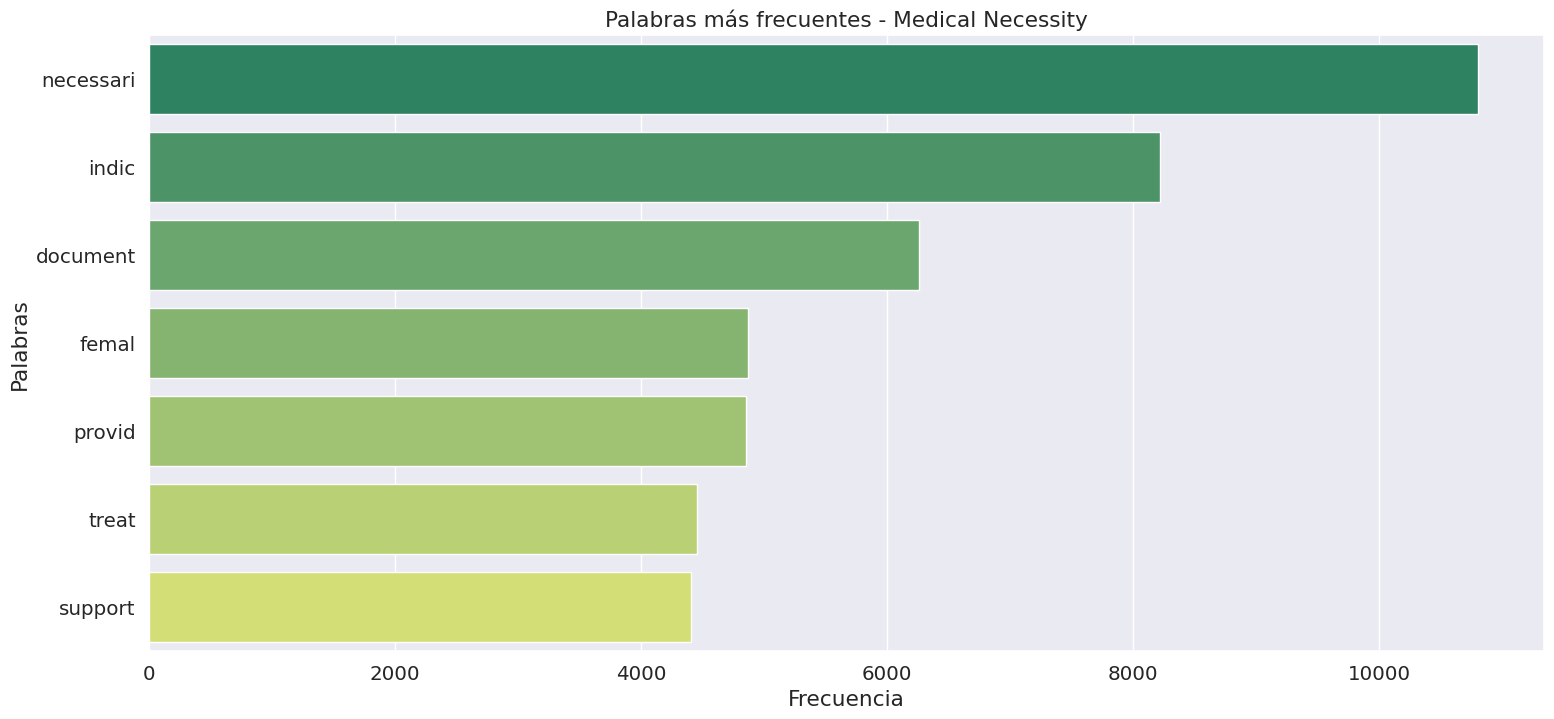

In [74]:
# Filtramos el df con las palabras no comunes
df0_difer = df0[df0.Word.isin(palabras_diferentes0)]

# Mostramos la información en un barplot
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df0_difer['Word'], x= df0_difer['Frequency'], palette= 'summer')
plt.title("Palabras más frecuentes - Medical Necessity")
plt.xlabel("Frecuencia")
plt.ylabel("Palabras")
plt.show()

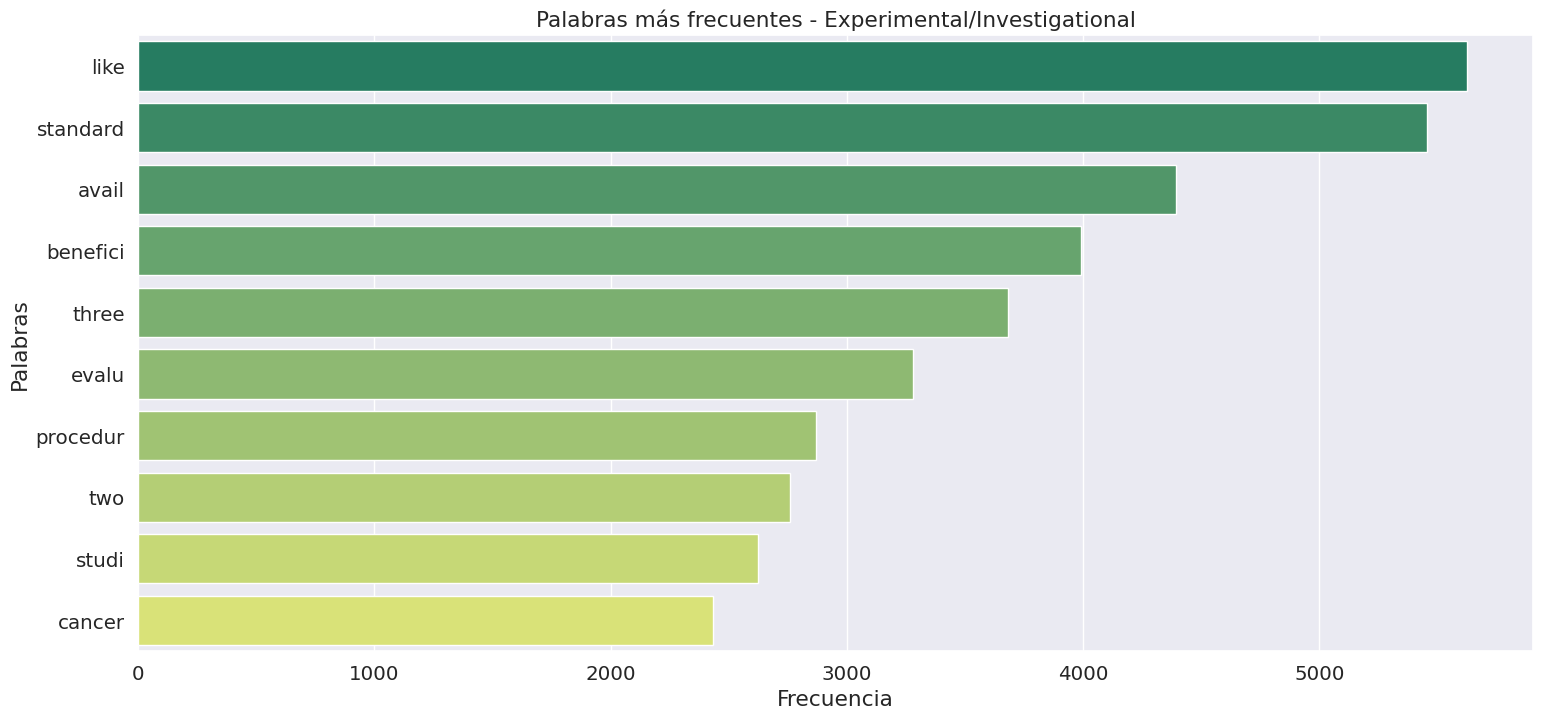

In [75]:
# Filtramos el df con las palabras no comunes
df1_difer = df1[df1.Word.isin(palabras_diferentes1)]

# Mostramos la información en un barplot
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df1_difer['Word'], x= df1_difer['Frequency'], palette= 'summer')
plt.title("Palabras más frecuentes - Experimental/Investigational")
plt.xlabel("Frecuencia")
plt.ylabel("Palabras")
plt.show()

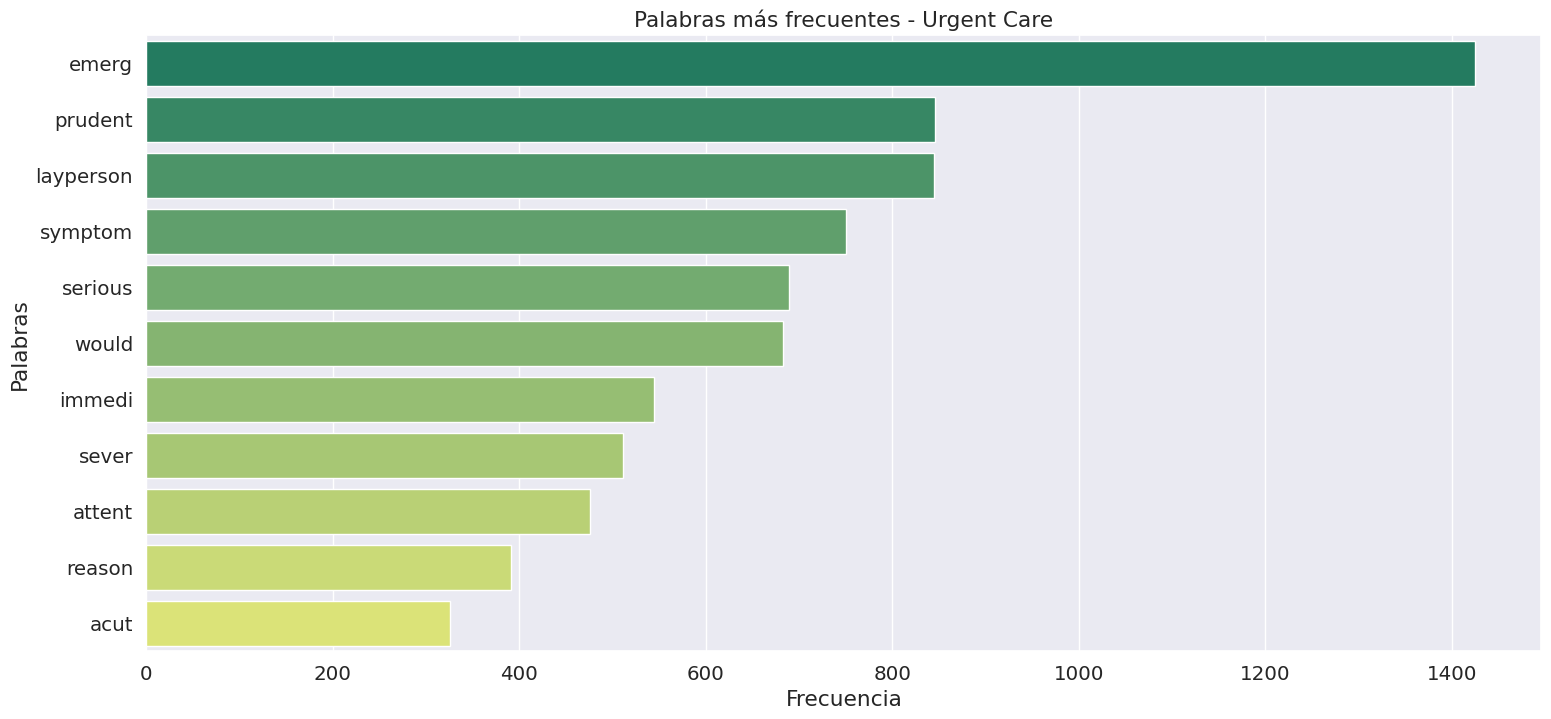

In [76]:
# Filtramos el df con las palabras no comunes
df2_difer = df2[df2.Word.isin(palabras_diferentes2)]

# Mostramos la información en un barplot
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df2_difer['Word'], x= df2_difer['Frequency'], palette= 'summer')
plt.title("Palabras más frecuentes - Urgent Care")
plt.xlabel("Frecuencia")
plt.ylabel("Palabras")
plt.show()

### Ejercicio 3

**(2 puntos)**

En este ejercicio, vamos a crear un modelo de clasificación para identificar el tipo de servicio médico a partir de la información textual preprocesada de la columna Findings.

a) Aplica la transformación de TF-IDF para representar el texto preprocesado en forma de vector. Usa la función `TfidfVectorizer`que hemos visto en teoría con un máximo de 2500 características (en la opción max_features). **(0.5 puntos)**

b) Separa los datos en un conjunto de train y de test, con un porcentaje de 80%-20%. El conjunto de train se usará para entrenar los datos y el conjunto de test, para validar los resultados del modelo. **(0.25 puntos)**

c) En este caso, tenemos un dataset desbalanceado. Para que esta situación no impacte tanto a los análisis, usa la función de oversampling [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) para tener el mismo número de muestras por grupo. **(0.25 puntos)**

d) Usa un modelo de [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) para predecir la clase label y muestra las métricas del modelo (accuracy, precision, recall, F2). Muestra también la matriz de confusión para ver como se distribuyen los resultados. **Interpreta y comenta los resultados.** **(1 punto)**

In [77]:
# a) TF-IDF

# Inicializamos la transformación de TfidfVectorizer
tfidf = TfidfVectorizer(max_features= 2500)

# Aplicamos la transformación a los datos
# Guardamos los datos transformados en un nuevo array
X_vec= tfidf.fit_transform(df_clf['Findings']).toarray()


In [78]:
# b) Separar dataset en train y test

# Queremos clasificar las muestras según el tipo (Type)

# Primero de todo, tenemos que preparar los datos
# 1) Separar datos en dataset de train y test

# Definimos la variable y
y = df_clf["Type_encoded"]

# Separamos el dataset en 80% train y 20% test
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size= 0.2, random_state= 42, stratify = y)

In [79]:
# c) Gestión del dataset desbalanceado

# Vemos que las clases estan descompensadas
df_clf["Type_encoded"].value_counts()

,count
Type_encoded,
0,10505
1,3913
2,401


In [80]:
from imblearn.over_sampling import SMOTE

# Aplicamos la técnica de Oversampling SMOTE
# Para generar más meustras de las clases pequeñas
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)

In [81]:
# El dataset de train ya está balanceado!
y_sm.value_counts()

,count
Type_encoded,
0,8404
1,8404
2,8404


In [82]:
#d) Modelo de Random Forest

# Ahora vamos a usar un algoritmo de random forest (RF) para predecir la clase

# Inicializamos el modelo de RF
rf = RandomForestClassifier(n_estimators= 300)

# Entranamos el modelo con los datos de train balanceados
rf.fit(X_sm, y_sm)

# Predecimos en el dataset de test
y_pred = rf.predict(X_test)

# Calculamos las métricas básicas
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, average='weighted'), 3)
recall = round(recall_score(y_test, y_pred, average='weighted'), 3)

# Mostramos por pantalla las métricas
print(f'Accuracy del modelo: {accuracy}')
print(f'Precisión del modelo: {precision}')
print(f'Recall del modelo: {recall}')

Accuracy del modelo: 0.972
Precisión del modelo: 0.972
Recall del modelo: 0.972


In [83]:
# Cargamos la función de classification_report
from sklearn.metrics import classification_report

# También se puede usar classification_report para sacar las métricas
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2101
           1       0.96      0.94      0.95       783
           2       0.99      0.91      0.95        80

    accuracy                           0.97      2964
   macro avg       0.97      0.95      0.96      2964
weighted avg       0.97      0.97      0.97      2964



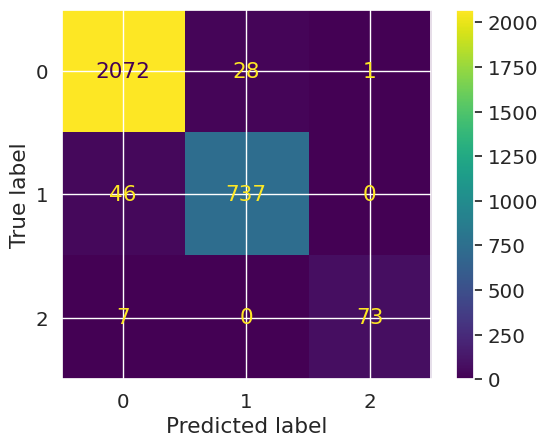

In [84]:
# Cargamos funciones para calcular y mostrar la matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)

# La visualizamos con la función ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot()
plt.show()

Desde un punto de vista clínico, los resultados son muy positivos y prometedores. El modelo es capaz de identificar correctamente el tipo de revisión a partir de la información de la columna Findings. Además, la clase minoritaria presenta también resultados óptimos, gracias a la técnica de oversampling aplicada durante el entrenamiento. En general, el modelo puede ser una herramienta de apoyo muy precisa para revisar rápidamente grandes volúmenes de decisiones médicas y clasificarlas adecuadamente.

### Ejercicio 4

(**1 punto**)

El modelo `d4data/biomedical-ner-all` es una herramienta de Reconocimiento de Entidades Nombradas (NER), especializada en identificar 107 tipos de entidades biomédicas en textos como informes de casos clínicos.

a) Usa este modelo para extraer las entidades de la columna original **Findings** y extrae las palabras más frecuentes según el tipo (mismo procedimiento que el ejercicio 3). ¿Por qué algunas palabras empiezan por ##? **(1 punto)**

b) Repite el modelo supervisado con las entidades identificadas. ¿Salen resultados parecidos? Comenta y razona tu respuesta. **(Opcional)**

**Nota**: Puedes descargarte el modelo a través de la API de Hugging Face, usando la librería transformers.

**Nota2**: El proceso de NER es lento (entre 30-45min), por lo tanto, se recomienda guardar el df con la nueva columna de las entidades para no tener que crearla cada vez.



In [85]:
# Cargamos la librería transformers
from transformers import pipeline

# Volvemos a cargar el dataset inicial para tener los valores originales
df = pd.read_csv("data/IMR_review.csv", sep=",")

# Eliminamos otra vez los NaNs
df = df.dropna()

In [86]:
# En media, el texto de Findings tiene unos 1.2k caracteres
list_findings = [len(x) for x in df["Findings"].astype(str)]
print("Media de caracteres: ", np.mean(list_findings))
print("Mediana de caracteres: ",np.median(list_findings))

# Hacemos un preproceso básico para limpiar el texto
# y reducir el número de caracteres
df['Findings'] = df['Findings'].apply(convert_lowercase)
df['Findings'] = df['Findings'].apply(remove_punc)
df['Findings'] = df['Findings'].apply(remove_stopwords)

# En media, el texto de Findings tiene, en media, unos 900 caracteres
# y en mediana, unos 800
list_findings = [len(x) for x in df["Findings"].astype(str)]
print("Media de caracteres: ", np.mean(list_findings))
print("Mediana de caracteres: ",np.median(list_findings))

Media de caracteres:  1256.5205479452054
Mediana de caracteres:  1090.0
Media de caracteres:  935.8919630204467
Mediana de caracteres:  812.0


In [87]:
## Parte comentada porque se proporciona el csv

# Cargamos el modelo
#ner_pipeline = pipeline("ner", model="d4data/biomedical-ner-all")

# Tratamos los 1k caracteres para que vaya más rápido
#df["Medical Entities"] = df["Findings"].astype(str).apply(lambda x: [ent["word"] for ent in ner_pipeline(x[:800])] if isinstance(x, str) else [])

In [88]:
#df.to_csv("data/IMR_review_ner_entities_clean.csv", index=False)

In [89]:
# Cargamos el df con la información de las entidades NER
df = pd.read_csv("data/IMR_review_ner_entities_clean.csv", sep=",")

In [90]:
# Mostramos las entidades
df["Medical Entities"]

,Medical Entities
0,"['nature', 'criteria', 'ha', '##r', '##i', 'he..."
1,"['rt', 'condition', 'physician', 'lack', 'trea..."
2,"['parent', 'speech', 'therapy', 'treatment', '..."
3,"['nature', 'breast', 'tom', '##os', '##yn', '#..."
4,"['nature', 'criteria', 'breast', 'tom', '##os'..."
...,...
14814,"['33', '##year', '##old', 'shoulder', 'surgery..."
14815,"['41', '##year', '##old', 'female', 'coverage'..."
14816,"['emergency', 'room', 'feb', '##ril', '##e', '..."
14817,"['fifty', '##se', '##ven', 'year', '##old', 'm..."


In [91]:
# a) Mostramos las entidades más frecuentes en función del tipo
# Repetimos el proceso del ejercicio 2

# Seleccionamos el texto según su tipo
text0 = df[df['Type'] == 'Medical Necessity']['Medical Entities']
text1 = df[df['Type'] == 'Experimental/Investigational']['Medical Entities']
text2 = df[df['Type'] == 'Urgent Care']['Medical Entities']

# Hacemos limpieza de la información ya que no nos aparece con el formato adecuado
text0_words = [text.replace("'", "").replace("[", "").replace("]", "").replace(",", "").split() for text in text0]
text0_words = [token for sublist in text0_words for token in sublist]
text1_words = [text.replace("'", "").replace("[", "").replace("]", "").replace(",", "").split() for text in text1]
text1_words = [token for sublist in text1_words for token in sublist]
text2_words = [text.replace("'", "").replace("[", "").replace("]", "").replace(",", "").split() for text in text2]
text2_words = [token for sublist in text2_words for token in sublist]

In [92]:
# Usamos Counter para sacar las 25 palabras más frecuentes
df0 = pd.DataFrame(Counter(text0_words).most_common(25), columns= ['Word', 'Frequency'])
df1 = pd.DataFrame(Counter(text1_words).most_common(25), columns= ['Word', 'Frequency'])
df2 = pd.DataFrame(Counter(text2_words).most_common(25), columns= ['Word', 'Frequency'])


In [93]:
# Creamos listas con las 25 palabras más frecuentes por tipo
df0_palabras = list(df0.Word)
df1_palabras = list(df1.Word)
df2_palabras = list(df2.Word)

# Miramos las palabras comunes en las 3 listas
palabras_comunes = list(set(df0_palabras) & set(df1_palabras) & set(df2_palabras))
palabras_comunes0_1 = list(set(df0_palabras) & set(df1_palabras) )
palabras_comunes0_2 = list(set(df0_palabras)  & set(df2_palabras))
palabras_comunes1_2 = list( set(df1_palabras) & set(df2_palabras))

# Para cada tipo nos quedamos con las palabras no comunes
palabras_diferentes0 = list(set(df0_palabras) ^ set(palabras_comunes) ^ set(palabras_comunes0_1) ^ set(palabras_comunes0_2))
palabras_diferentes1 = list(set(df1_palabras) ^ set(palabras_comunes) ^ set(palabras_comunes0_1) ^ set(palabras_comunes1_2))
palabras_diferentes2 = list(set(df2_palabras) ^ set(palabras_comunes) ^ set(palabras_comunes0_2) ^ set(palabras_comunes1_2))

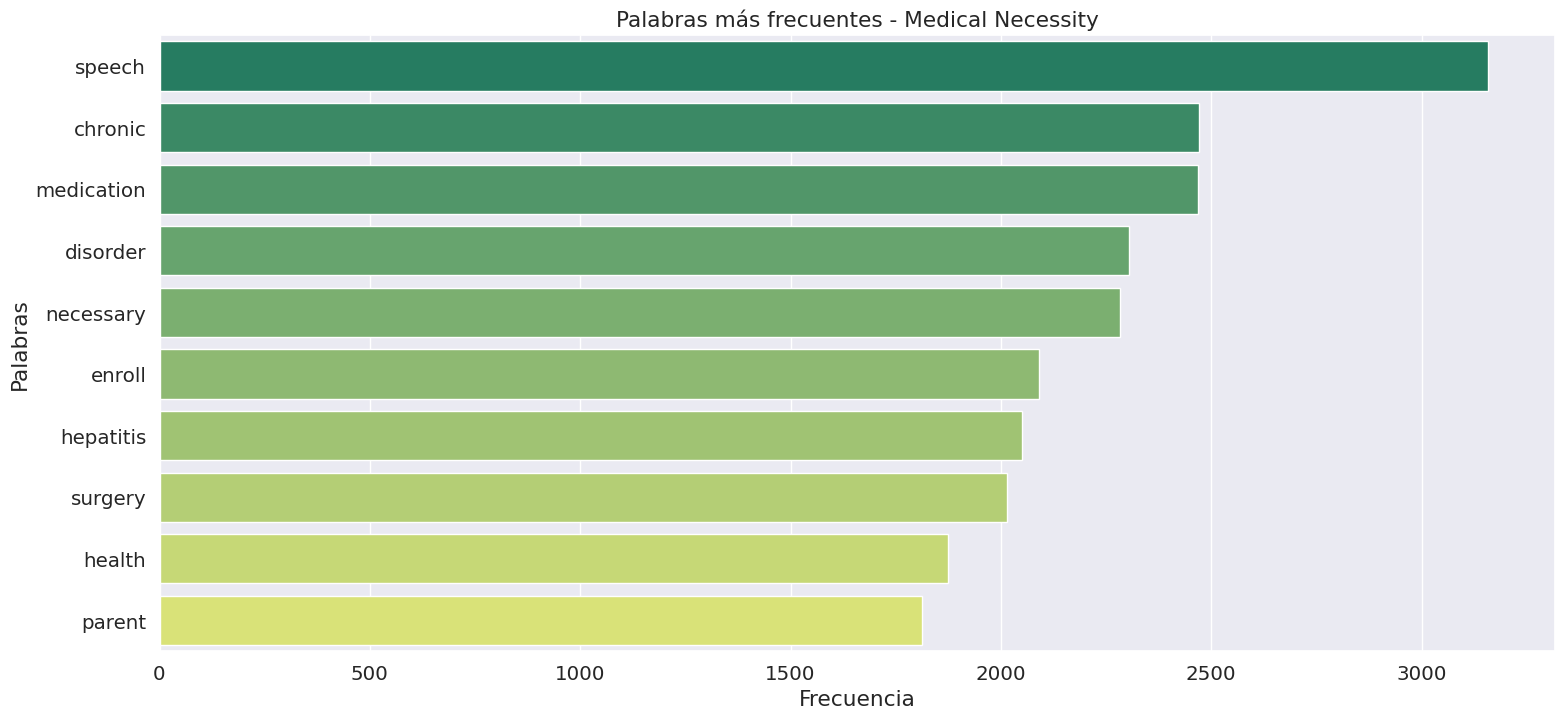

In [94]:
# Filtramos el df con las palabras no comunes
# También miramos que contengan más de una letra
df0_difer = df0[(df0.Word.isin(palabras_diferentes0)) & (df0['Word'].str.len() > 1)]

# Mostramos la información en un barplot
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df0_difer['Word'], x= df0_difer['Frequency'], palette= 'summer')
plt.title("Palabras más frecuentes - Medical Necessity")
plt.xlabel("Frecuencia")
plt.ylabel("Palabras")
plt.show()

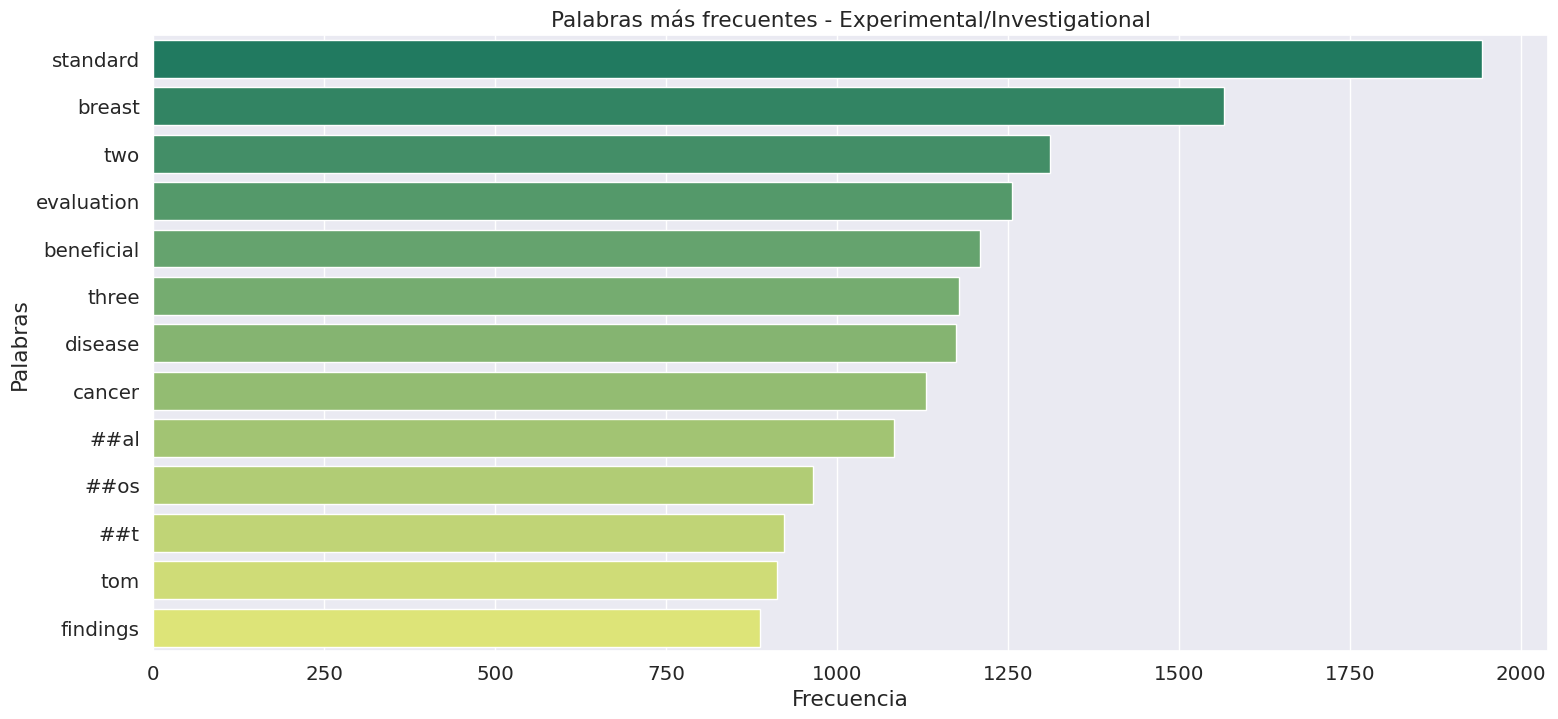

In [95]:
# Filtramos el df con las palabras no comunes
df1_difer = df1[(df1.Word.isin(palabras_diferentes1)) & (df1['Word'].str.len() > 1)]

# Mostramos la información en un barplot
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df1_difer['Word'], x= df1_difer['Frequency'], palette= 'summer')
plt.title("Palabras más frecuentes - Experimental/Investigational")
plt.xlabel("Frecuencia")
plt.ylabel("Palabras")
plt.show()

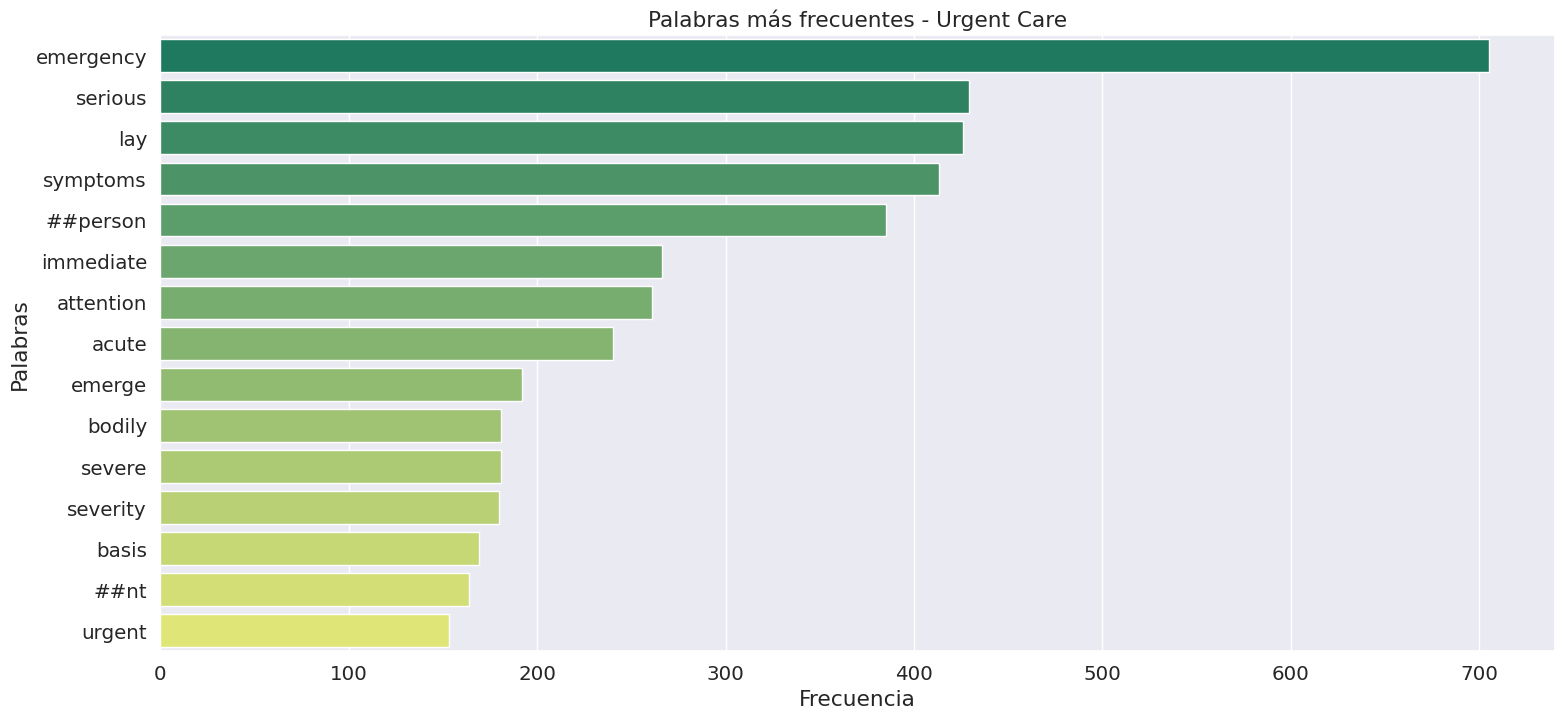

In [96]:
# Filtramos el df con las palabras no comunes
df2_difer = df2[(df2.Word.isin(palabras_diferentes2)) & (df2['Word'].str.len() > 1)]

# Mostramos la información en un barplot
sns.set_context('notebook', font_scale= 1.3)
plt.figure(figsize=(18,8))
sns.barplot(y = df2_difer['Word'], x= df2_difer['Frequency'], palette= 'summer')
plt.title("Palabras más frecuentes - Urgent Care")
plt.xlabel("Frecuencia")
plt.ylabel("Palabras")
plt.show()

In [97]:
# b) Volvemos a entrenar el modelo supervisado

## 1) TF-IDF

# Inicializamos la transformación de TfidfVectorizer
tfidf = TfidfVectorizer(max_features= 2500)

# Aplicamos la transformación a los datos
# Guardamos los datos transformados en un nuevo array
# Para aplicar TF-IDF tiene que ser un texto todo junto
text_all = df['Medical Entities']
text_all_words = [text.replace("'", "").replace("[", "").replace("]", "").replace(",", "").split() for text in text_all]
df['Medical_Entities_joined'] = [' '.join(text) for text in text_all_words]

X_vec= tfidf.fit_transform(df['Medical_Entities_joined']).toarray()

## 2) Separamos datos en dataset de train y test

# Definimos la variable y
df["Type_encoded"] = df["Type"].replace({
        "Medical Necessity" : 0,
        "Experimental/Investigational": 1,
        "Urgent Care": 2
})
y = df["Type_encoded"]

# Separamos el dataset en 80% train y 20% test
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size= 0.2, random_state= 42, stratify = y)

## 3) SMOTE

# Aplicamos la técnica de Oversampling SMOTE
# Para generar más meustras de las clases pequeñas
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train, y_train)

## 4) Modelo de Random Forest

# Ahora vamos a usar un algoritmo de random forest (RF) para predecir la clase

# Inicializamos el modelo de RF
rf = RandomForestClassifier(n_estimators= 300)

# Entranamos el modelo con los datos de train balanceados
rf.fit(X_sm, y_sm)

# Predecimos en el dataset de test
y_pred = rf.predict(X_test)

# Calculamos las métricas básicas
accuracy = round(accuracy_score(y_test, y_pred), 3)
precision = round(precision_score(y_test, y_pred, average='weighted'), 3)
recall = round(recall_score(y_test, y_pred, average='weighted'), 3)

# Mostramos por pantalla las métricas
print(f'Accuracy del modelo: {accuracy}')
print(f'Precisión del modelo: {precision}')
print(f'Recall del modelo: {recall}')

Accuracy del modelo: 0.925
Precisión del modelo: 0.925
Recall del modelo: 0.925


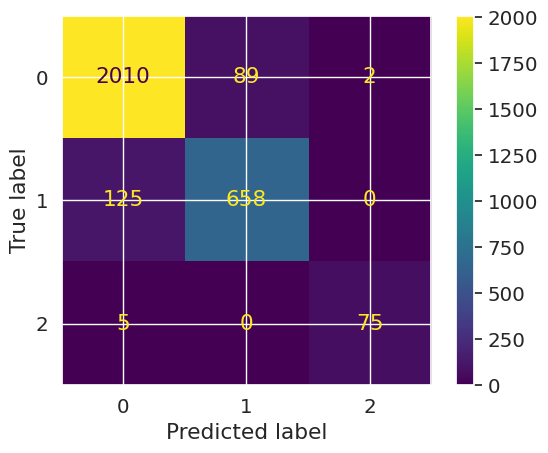

In [98]:
# Cargamos funciones para calcular y mostrar la matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)

# La visualizamos con la función ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rf.classes_)
disp.plot()
plt.show()

Al repetir el modelo supervisado utilizando únicamente las entidades identificadas por el modelo NER, los resultados son algo inferiores (accuracy 0.929 frente a 0.973). Esto puede deberse a la pérdida de contexto al reducir el texto original a 800 caracteres y centrarse solo en las entidades, lo que limita la riqueza semántica. Como consecuencia, el modelo empeora su capacidad de identificar correctamente el tipo de caso, especialmente en la categoría experimental. Aunque el rendimiento sigue siendo alto, el uso del texto completo proporciona una información más completa y efectiva en este ejercicio.
